In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn import linear_model
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import ensemble
from sklearn import decomposition
from sklearn import dummy
import xgboost as xgb

from IPython.display import display
from src import display_all
#import importlib,sys
#importlib.reload(sys.modules['src'])
#from src import display_all

import time
import itertools
import math

import shap

/opt/anaconda/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Chargement données

In [2]:
data = pd.read_csv('./data/Pelec_clean.csv', index_col = 0)

### Grid of Grid search

In [3]:
def max_dict_value(dict):
    k = max(dict,key=lambda k: dict[k])
    return (k,dict[k])

class gridOfgridsearchCV:
    """
    API:
    -fit:
    -test:
    -predict:
    -run: fit + test + predict

    -get_score
    -get_predict
    -get_estimator
    -get_gs

    """
    __random_state__ = 777
    
    def __init__(self,config,refit=None,scoring=[],n_jobs=2,scale_all=True,scale_predict=None):
        
        if refit is not None:
            if refit not in scoring.keys():
                raise ValueError( f"refit '{refit}' is not a scoring")
            self.__refit__   = refit
            self.__scoring__ = scoring
        else:
            self.__refit__    = True
            self.__scoring__  = None

        self.__scale_predict__ = scale_predict
        self.__scale_all__    = scale_all
        self.__n_jobs__       = n_jobs
        self.__grid_config__  = config
        
        self.reset()
    
    def reset(self):
        self.__best__          = None
        self.__grid_searchs__  = {}
        self.__tests__         = {}
        self.__predicts__      = None
        self.__shap_values__   = None
        self.__explainer__     = None

    def fit(self,X_train,y_train):
        for estimator in self.__grid_config__.keys(): 
            gs = model_selection.GridSearchCV(self.__build_pipe__(estimator) , self.__build_grid_param__(estimator),refit=self.__refit__,scoring=self.__scoring__,error_score='raise')
            try:
                gs.fit(X_train,y_train)
            except BaseException as err:
                print(f"{estimator} - Unexpected {err=}, {type(err)=}")
            self.__grid_searchs__[estimator] = gs
        
    def run(self,data,y,excluded_features=[],test_size=0.2):
        # split train, test
        selected_columns = list(filter(lambda x: x not in excluded_features+[y],data.columns.values))
        X_train,X_test,y_train,y_test  = model_selection.train_test_split(data.loc[:,selected_columns],data.loc[:,y],test_size=test_size,random_state=self.__random_state__)
        #fit models with gridsearch CV
        self.fit(X_train,y_train)
        # test (compute scores)
        self.test(X_test,y_test)
        # select best estimator
        self.__select_best__()
        #predicts
        if self.__scale_predict__ is None:
            self.__predicts__ = (y_test,self.predict(X_test))
        else:
            self.__predicts__ = (self.__scale_predict__(y_test),self.predict(X_test))
        #shap values
        p = self.get_estimator(est=self.best(),pipe=True)
        model = p[-1]
        trans = p[0:-1]
        if self.__scale_predict__ is None:
            self.__explainer__ = shap.Explainer(lambda x: model.predict(x),trans.transform(X_train))
        else:
            self.__explainer__ = shap.Explainer(lambda x: self.__scale_predict__(model.predict(x)),trans.transform(X_train))
        
        error = abs(self.__predicts__[0]-self.__predicts__[1][self.__best__][0])
        self.__shap_values__ = list(map(lambda f: f(error),[np.argmin,np.argmax])) + [self.__explainer__(pd.DataFrame(trans.transform(X_test),columns=selected_columns))]

    def __is_multiscores__(self):
        return isinstance(self.__refit__,str)

    def __is_estimator__(self,estimator):
        if estimator not in self.__grid_searchs__.keys():
             raise ValueError( f"'{estimator}' not an estimator")

    def __test_est__(self,est,X,y):
        estimator = self.__grid_searchs__[est].best_estimator_
        if self.__is_multiscores__():
            return {score:scorer(estimator,X,y) for (score,scorer) in self.__scoring__.items()}
        else:
            return self.__grid_searchs__[est].scorer_(estimator,X,y)

    def test(self,X,y,estimator='all'):
        if estimator == 'all':
            for estimator in self.__grid_config__.keys():
                self.__tests__[estimator] = self.__test_est__(estimator,X,y)
        else:
            self.__is_estimator__(estimator)
            self.__tests__[estimator] = self.__test_est__(estimator,X,y)

    def __predict_est__(self,est,X):
            start = time.process_time()
            y_predict = self.__grid_searchs__[est].best_estimator_.predict(X)
            if self.__scale_predict__ is not None:
                y_predict = self.__scale_predict__(y_predict)
            elapsed = (time.process_time() - start)
            return (y_predict,elapsed)

    def predict(self,X,estimator='all'):
        if estimator == 'all':
            return {estimator: self.__predict_est__(estimator,X) for estimator in self.__grid_config__.keys()}
        else:
            self.__is_estimator__(estimator)
            return self.__predict_est__(estimator,X)

    def get_predict(self,estimator='all'):
        if self.__predicts__ is not None:
            if estimator == 'all':
                return self.__predicts__
            else:
                self.__is_estimator__(estimator)
                return (self.__predicts__[0],self.__predicts__[1].get(estimator,np.NAN))

    def __select_best__(self):
        if self.__tests__ is not None:
            
            if self.__is_multiscores__():
                scores = {estimator:self.__tests__[estimator][self.__refit__] for estimator in self.__grid_config__.keys()}     
            else:
                scores = self.__tests__
        
            self.__best__ = max(scores,key=lambda k: scores[k])

    # To do: improve score management
    def __handle_key__(self,key,est):
        if key in self.__grid_config__[est]['params'].keys():
            return f'param_{est}__{key}'
        elif self.__is_multiscores__() and key == 'mean_test_score':
            return 'mean_test_'+ self.__refit__
        else:
            return key

    def best(self):
        return self.__best__
    
    def get_estimator(self,est=None,pipe=False):
        if est is None:
            pipe_ = self.__grid_searchs__[self.__best__].best_estimator_ if self.__best__ is not None else None
        else:
            self.__is_estimator__(est)
            pipe_ = self.__grid_searchs__[est].best_estimator_
            
        if pipe is True or pipe_ is None:
            return pipe_
        else:
            steps_ = pipe_.get_params()['steps'] 
            n = len(steps_) - 1
            return steps_[n][1] 

    def __score__(self,score):
        if not(self.__is_multiscores__()):
            return
        if score not in self.__scoring__.keys() and score not in ['refit','all']:
            raise ValueError(f"{score} not a score")
        if score == 'refit':
                return self.__refit__

    def get_score(self,estimator='all',score='refit'):
        score_ = self.__score__(score)
        if self.__tests__ is not None:
            if score_ is None:
                if estimator == 'all':
                    return self.__tests__
                else:
                    self.__tests__.get(estimator,np.NAN)
            else:
                if estimator == 'all':
                    if score == 'all':
                        return self.__tests__
                    else:
                        return {estimator:scores[score_] for (estimator,scores) in self.__tests__.items()}

    def __get_est_k__(self,key,est,level):
        """
            helping function for get_gs
        """
        k = self.__handle_key__(key,est)
        gs = self.__grid_searchs__[est]
        rs = gs.cv_results_.get(k)
        if rs is None:
            return None
        if level == 'best':
            return rs[gs.best_index_]
        elif level == 'all':
            return rs

    def __get_est__(self,keys,est,level):
        """
            helping function for get_gs
        """
        if isinstance(keys,str):
            return self.__get_est_k__(keys,est,level)
        else:
            return {key:self.__get_est_k__(key,est,level) for key in keys if self.__get_est_k__(key,est,level) is not None }

    def get_gs(self,key,estimator='best',level='best'):
        """
            get key value in grid of gridsearchs
        """
        if estimator == 'best':
            est = self.__best__
            return self.__get_est__(key,est,level)
        elif estimator == 'all':
            return {est:self.__get_est__(key,est,level) for est in self.__grid_config__.keys()}
        else:
            self.__is_estimator__(estimator)
            return self.__get_est__(key,estimator,level)

    def __build_pipe__(self,estimator):
        # scale
        scale = self.__grid_config__[estimator].get('scale',True)
        scale = (scale and self.__scale_all__) or scale
        # add predefined steps
        steps_ = ( [('scale',preprocessing.StandardScaler())] if scale else [] ) + self.__grid_config__[estimator].get('pipe',[])
        # constructor
        ctor = self.__grid_config__[estimator]['estimator']
        # build pipe
        return pipeline.Pipeline(steps=(steps_ + [(estimator,ctor())]))

    def __build_grid_param__(self,estimator):
        return {f'{estimator}__{k}': v for (k,v) in self.__grid_config__[estimator]['params'].items()}


### Helping Functions

In [4]:
params = ['alpha','n_estimators','l1_ratio','base_estimator__alpha','learning_rate','max_samples','max_features','max_depth']

def print_key(grid,key,estimator_='all',level_='best',alias = None):
    label = alias if alias is not None else key
    print(f"{label}: {grid.get_gs(key,estimator=estimator_,level=level_)}")

def dump(grid):
    print(f"Best  estimator: {grid.best()}")
    print(f"R2 (test): {grid.get_score()}")
    print_key(grid,'mean_test_score',alias='R2 (train)')
    print_key(grid,params,alias='hyper-parameters')

def coefs(grid,estimators):
    p = grid.get_estimator(est=estimators[0],pipe=True)
    features = p[:-1].get_feature_names_out()
    n = len(features)
    data = [list(zip(grid.get_estimator(est=estimator).coef_,features,[estimator]*n )) for estimator in estimators ] 
    return pd.DataFrame(data=list(itertools.chain.from_iterable(data)),columns=['coef','feature','estimator'])

def display_coefs(df,y):
    g = sns.catplot(data=df,x='feature',y='coef',hue='estimator',height=8,aspect=2)
    g.set_xticklabels(g.ax.get_xticklabels(),rotation=45, ha='right')
    g.ax.grid(True)
    g.ax.set_title(y)
    plt.show()
    return g
    
def merge_score(grid):
    scores_maps = list(grid.get_score(score='all').values())
    ret = {}
    for score in scores_maps[0].keys():
        ret[score] = list(map(lambda m: m[score],scores_maps))
    return ret

def gridinfo(grid):
    (_,dict) = grid.get_predict()
    return pd.DataFrame({
        **{'estimator':grid.get_gs('mean_fit_time',estimator='all').keys()},
        **merge_score(grid),
        **{'fit_time':grid.get_gs('mean_fit_time',estimator='all').values()},
        **{'params':grid.get_gs(params,estimator='all').values()},
        **{'predict_time':list(map(lambda x: x[1],dict.values() ) )},
        **{'R2_train':grid.get_gs('mean_test_R2',estimator='all').values()}
    }
    )
    
def global_results(results):
    tmp = []
    for (target,gs) in results.items():
        df = gridinfo(gs)
        df['target'] = [target]*len(df)
        tmp.append(df)

    return pd.concat(tmp,ignore_index=True)

def display_predict(y,gs,est=None):
    if est is None:
        est = gs.best()
    (y_true,(y_predict,_))  = gs.get_predict(estimator=est)
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(24,12),sharex=True)
    t = range(len(y_true))
    _ = ax1.plot(t,y_true,color='blue')
    _ = ax1.plot(t,y_predict,color='red')
    ax1.set_ylabel(y)
    legend_handles = [ Line2D([],[],color=c,label=l)  for (l,c) in {'true values':'blue',f'predicted values ({est})':'red'}.items()]
    ax1.legend(handles=legend_handles,loc='upper center')
    ax1.set_title(y)
    _ = ax2.plot(t,abs(y_true-y_predict))
    ax2.set_title("|Error|")
    g = sns.relplot(data=pd.DataFrame({'y_true':y_true,'y_predict':y_predict}),x='y_true',y='y_predict',height=10,aspect=2,kind='scatter')
    max = math.ceil(y_true.max()+1)
    g.ax.plot([0,max],[0,max],color='red')

def display_shap(y,gs):
    [i,j,shap_values] = gs.__shap_values__
    (y_true,_) = gs.get_predict(estimator=gs.best())
    plt.gca().set_title(f'Shap values - {y}')
    shap.plots.beeswarm(shap_values,max_display=40)
    plt.gca().set_title(f'Best prediction (True value:{y_true.iloc[i]: .2f})')
    shap.plots.waterfall(shap_values[i],max_display=40)
    plt.gca().set_title(f'Worse prediction (True value:{y_true.iloc[j]: .2f})')
    shap.plots.waterfall(shap_values[j],max_display=40)

### Polynomial features

In [5]:
from sklearn.base import TransformerMixin

class PolyWithSelection(TransformerMixin):
    """
    Transformer for manual selection of features using sklearn style 
    transform method.  
    """

    def __init__(self, features,n):
        self.__features__ = features
        self.__n__ = n
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        poly = preprocessing.PolynomialFeatures(self.__n__,include_bias=False,interaction_only=True)
        columns = X.columns.values
        features = list(filter(lambda x: x in columns ,self.__features__))
        Px = poly.fit_transform(X.loc[:,features])
        (_,n) = Px.shape
        Pf = pd.DataFrame(Px,index=X.index,columns=list(map(lambda x: str(x),range(1,n+1))))
        return pd.concat([X,Pf],axis=1)


### Modèles

In [6]:
alpha_ridge = range(1,20,1)
alpha_lasso = np.arange(0.001,0.1,0.001)
alpha_elasticNet = np.arange(0.001,0.1,0.001)
l1_ratio = np.arange(0.1,1,0.1)

rf_max_samples  = [0.2,0.5,0.8,1] 
rf_max_features = [0.2,0.5,0.8,1]
gb_max_depth = [3,4,5,10,20]
n_estimators = range(60,210,20)

learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

max_iter = 100000

scoring = {
    'R2'      : metrics.make_scorer(metrics.r2_score),
    'MAE_neg' : metrics.make_scorer(metrics.mean_absolute_error, greater_is_better=False),
    'MSE_neg' : metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)
}

grid_config_base = { 
'Dummy':           {'estimator':dummy.DummyRegressor,'params':{'strategy':['median']}},    
'Ridge':           {'estimator':linear_model.Ridge,'params':{'alpha':alpha_ridge}},
'Lasso':           {'estimator':linear_model.Lasso,'params':{'alpha':alpha_lasso,'precompute':[True],'max_iter':[max_iter]}},
'ElasticNet':      {'estimator':linear_model.ElasticNet,'params':{'alpha':alpha_elasticNet,'l1_ratio':l1_ratio,'precompute':[True],'max_iter':[max_iter]}},
'Tree Bagging':    {'estimator':ensemble.BaggingRegressor,'params':{'n_estimators':n_estimators}},
'RandomForest':    {'estimator':ensemble.RandomForestRegressor,'params':{'n_estimators':n_estimators,'bootstrap':[True],'max_samples':rf_max_samples,'max_features':rf_max_features}},
'GBoost':          {'estimator':ensemble.GradientBoostingRegressor,'params':{'n_estimators':n_estimators, 'learning_rate' : learning_rate,'max_depth':gb_max_depth} },
'XGBoost':         {'estimator':xgb.XGBRegressor,'params':{'n_estimators':n_estimators, 'learning_rate' : learning_rate,'max_depth':gb_max_depth, 'objective':['reg:squarederror']}},
'Bagging w Ridge': {'estimator':ensemble.BaggingRegressor,'params':{'n_estimators':n_estimators,'base_estimator':[linear_model.Ridge()],'base_estimator__alpha':alpha_ridge}},
}

grid_config_Pfeatures_GHCE = {
'RandomForest w Pfeatures 2': {
    'estimator':ensemble.RandomForestRegressor,
    'params':{'n_estimators':n_estimators},
    'scale':False,
    'pipe':[('Pfeatures',PolyWithSelection(['c_TotalGFA_mean','ENERGYSTARScore_mean','c_PropertyType_<Warehouse>','c_MainEnergy_<Electricity(kBtu)>'],2)),('scale',preprocessing.StandardScaler())]   
    },
'Ridge w Pfeatures 2': {
        'estimator':linear_model.Ridge,
        'scale':False,
        'params':{'alpha':alpha_ridge},
        'pipe':[('Pfeatures',PolyWithSelection(['c_TotalGFA_mean','ENERGYSTARScore_mean','c_PropertyType_<Warehouse>','c_MainEnergy_<Electricity(kBtu)>'],2)),('scale',preprocessing.StandardScaler())]   
    }
}

grid_config_Pfeatures_Energy = {
'RandomForest w Pfeatures 2': {
    'estimator':ensemble.RandomForestRegressor,
    'params':{'n_estimators':n_estimators},
    'scale':False,
    'pipe':[
            ('Pfeatures',PolyWithSelection(['c_TotalGFA_mean','ENERGYSTARScore_mean','c_PropertyType_<Worship Facility>','c_PropertyType_<Warehouse>','c_PropertyType_<Large Office>'],2)),
            ('scale',preprocessing.StandardScaler())
        ]   
    },
'Ridge w Pfeatures 2': {
        'estimator':linear_model.Ridge,
        'scale':False,
        'params':{'alpha':alpha_ridge},
        'pipe':[
                ('Pfeatures',PolyWithSelection(['c_TotalGFA_mean','ENERGYSTARScore_mean','c_PropertyType_<Worship Facility>','c_PropertyType_<Warehouse>','c_PropertyType_<Large Office>'],2)),
                ('scale',preprocessing.StandardScaler())
            ]   
    }
}

### Grid Search

In [7]:
tbe = ['GHGEmissions_mean','SiteEnergyUse_comp_mean']
es = 'ENERGYSTARScore_mean'
reg_estimators = ['Ridge','Lasso','ElasticNet']

results = {}
for excluded in tbe:
    y = list(set(tbe) - set([excluded]))[0]
    if y == 'GHGEmissions_mean':
        grid_config = {**grid_config_base,**grid_config_Pfeatures_GHCE }
    else:
        grid_config = {**grid_config_base,**grid_config_Pfeatures_Energy}

    g1 = gridOfgridsearchCV(grid_config,scoring=scoring,refit='R2',scale_predict=np.exp)
    g1.run(data,excluded_features=[excluded],y=y)
    results[y.split('_')[0] + ' w Energy Star'] = g1
    g2 = gridOfgridsearchCV(grid_config,scoring=scoring,refit='R2',scale_predict=np.exp)
    g2.run(data,excluded_features=[excluded]+[es],y=y)
    results[y.split('_')[0] + ' wo Energy Star'] = g2
    

Permutation explainer: 298it [00:31,  6.94it/s]                         
Permutation explainer: 298it [00:17,  6.21it/s]                         
Permutation explainer: 298it [00:26,  6.89it/s]                         
Permutation explainer: 298it [00:21,  6.77it/s]                         


### Affichage résultats

=== Global Results ===


,target,estimator,R2_test,MAE_neg,MSE_neg,R2_train,predict_time,fit_time,params
0,SiteEnergyUse w Energy Star,Dummy,-0.016499,-0.992908,-1.508583,-0.017391,0.010835,0.013696,{}
1,SiteEnergyUse w Energy Star,Ridge,0.734915,-0.497188,-0.393412,0.645057,0.010595,0.008022,{'alpha': 19}
2,SiteEnergyUse w Energy Star,Lasso,0.733906,-0.495452,-0.394909,0.646536,0.009353,0.008410,{'alpha': 0.012}
3,SiteEnergyUse w Energy Star,ElasticNet,0.732845,-0.495741,-0.396484,0.646700,0.008902,0.008095,"{'alpha': 0.025, 'l1_ratio': 0.4}"
4,SiteEnergyUse w Energy Star,Tree Bagging,0.818240,-0.371596,-0.269750,0.822406,0.168915,1.602460,{'n_estimators': 160}
5,SiteEnergyUse w Energy Star,RandomForest,0.811331,-0.384148,-0.280003,0.822707,0.157924,1.285368,"{'n_estimators': 180, 'max_samples': 0.8, 'max_features': 0.8}"
6,SiteEnergyUse w Energy Star,GBoost,0.868321,-0.318485,-0.195425,0.862363,0.015790,0.676428,"{'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 3}"
7,SiteEnergyUse w Energy Star,XGBoost,0.893413,-0.297663,-0.158185,0.864702,0.023955,0.139344,"{'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 3}"
8,SiteEnergyUse w Energy Star,Bagging w Ridge,0.729294,-0.499122,-0.401753,0.647262,0.093846,0.231609,"{'n_estimators': 60, 'base_estimator__alpha': 19}"
9,SiteEnergyUse w Energy Star,RandomForest w Pfeatures 2,0.812919,-0.377803,-0.277646,0.820789,0.422042,2.265967,{'n_estimators': 180}


(44, 9)
=== SiteEnergyUse w Energy Star ===


,estimator,R2,MAE_neg,MSE_neg,fit_time,params,predict_time,R2_train
0,Dummy,-0.016499,-0.992908,-1.508583,0.013696,{},0.010835,-0.017391
1,Ridge,0.734915,-0.497188,-0.393412,0.008022,{'alpha': 19},0.010595,0.645057
2,Lasso,0.733906,-0.495452,-0.394909,0.008410,{'alpha': 0.012},0.009353,0.646536
3,ElasticNet,0.732845,-0.495741,-0.396484,0.008095,"{'alpha': 0.025, 'l1_ratio': 0.4}",0.008902,0.646700
4,Tree Bagging,0.818240,-0.371596,-0.269750,1.602460,{'n_estimators': 160},0.168915,0.822406
5,RandomForest,0.811331,-0.384148,-0.280003,1.285368,"{'n_estimators': 180, 'max_samples': 0.8, 'max_features': 0.8}",0.157924,0.822707
6,GBoost,0.868321,-0.318485,-0.195425,0.676428,"{'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 3}",0.015790,0.862363
7,XGBoost,0.893413,-0.297663,-0.158185,0.139344,"{'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 3}",0.023955,0.864702
8,Bagging w Ridge,0.729294,-0.499122,-0.401753,0.231609,"{'n_estimators': 60, 'base_estimator__alpha': 19}",0.093846,0.647262
9,RandomForest w Pfeatures 2,0.812919,-0.377803,-0.277646,2.265967,{'n_estimators': 180},0.422042,0.820789


(11, 8)


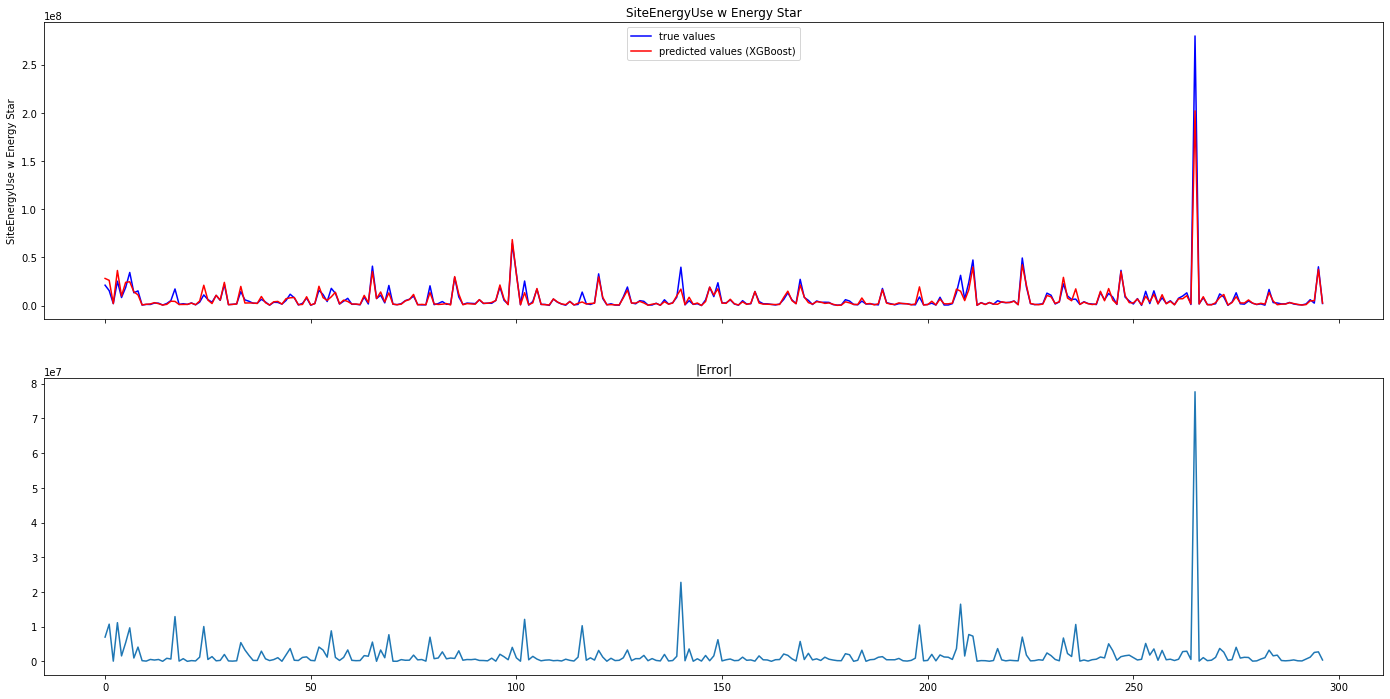

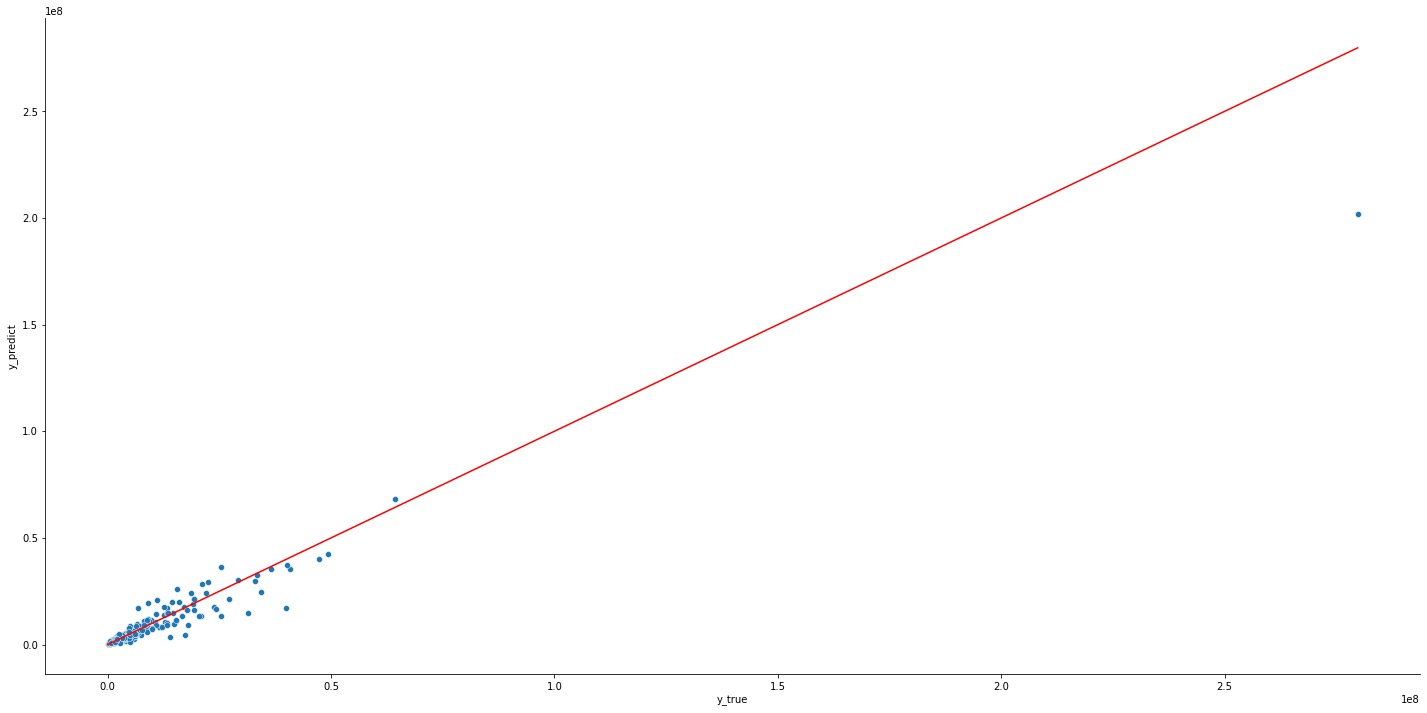

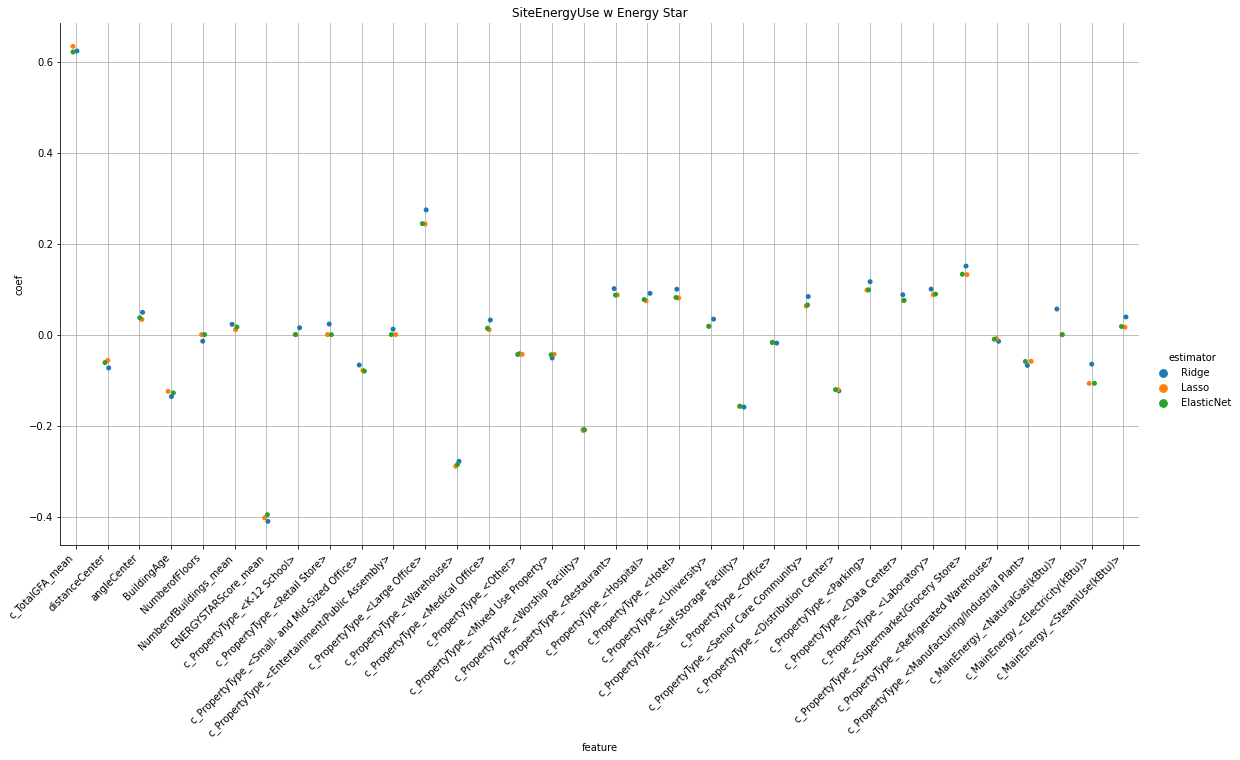

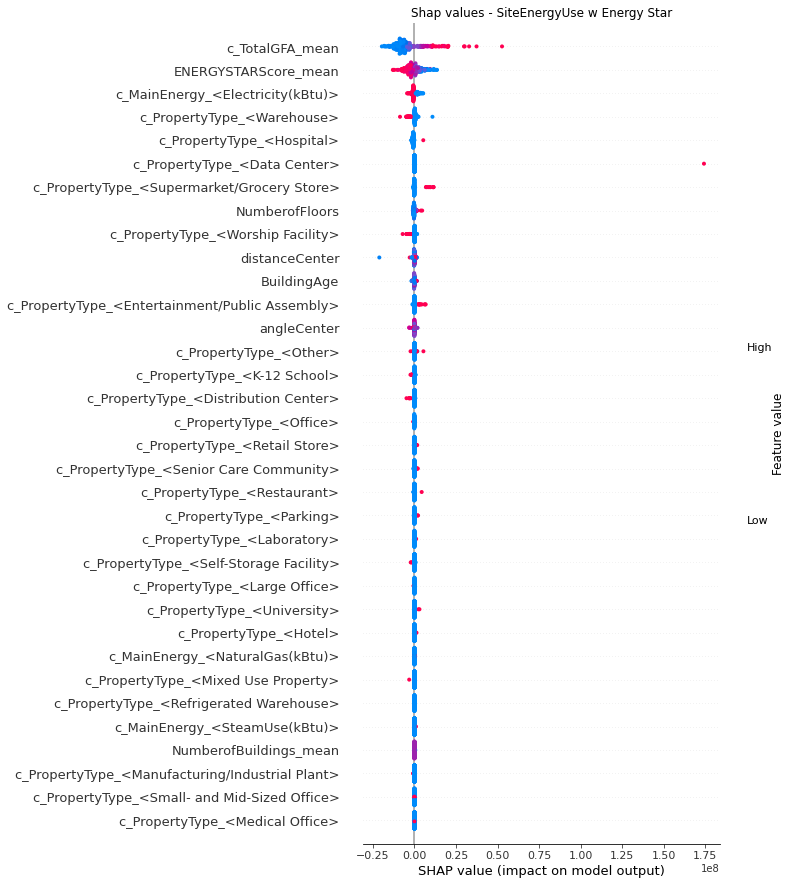

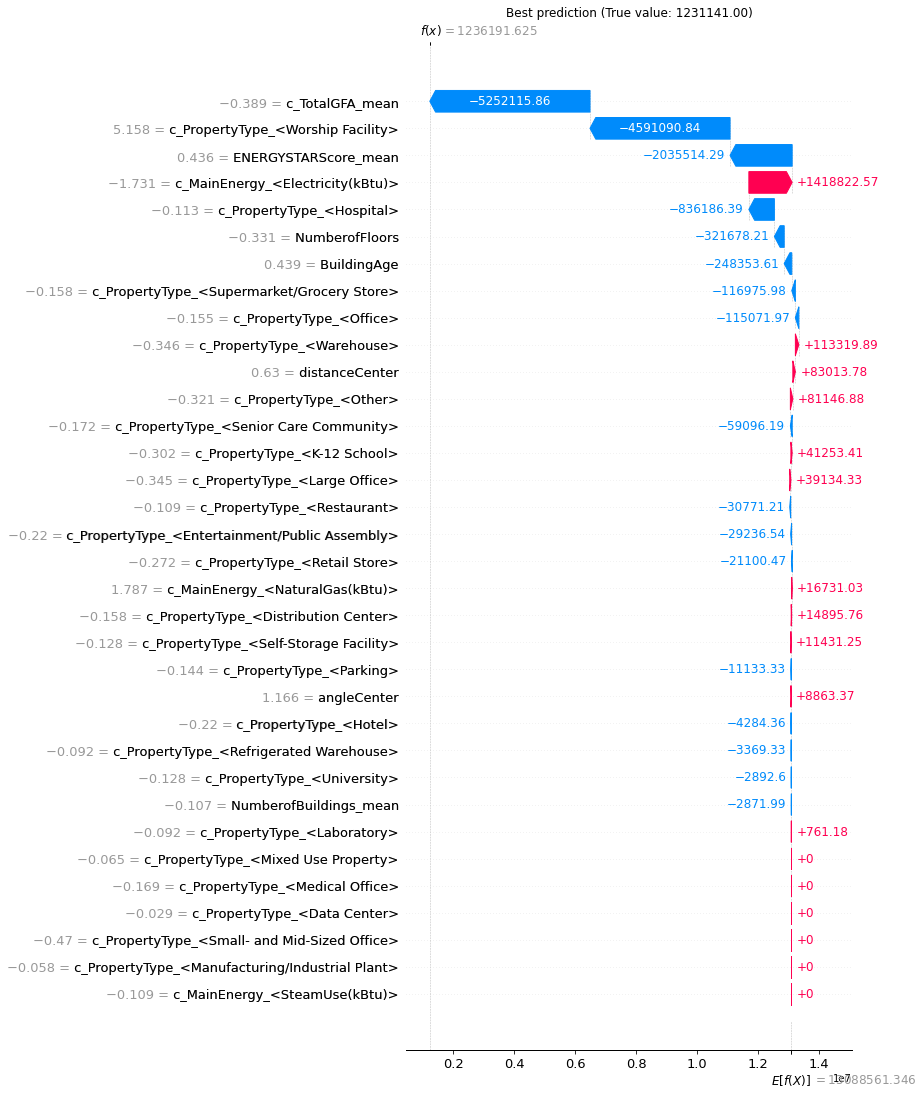

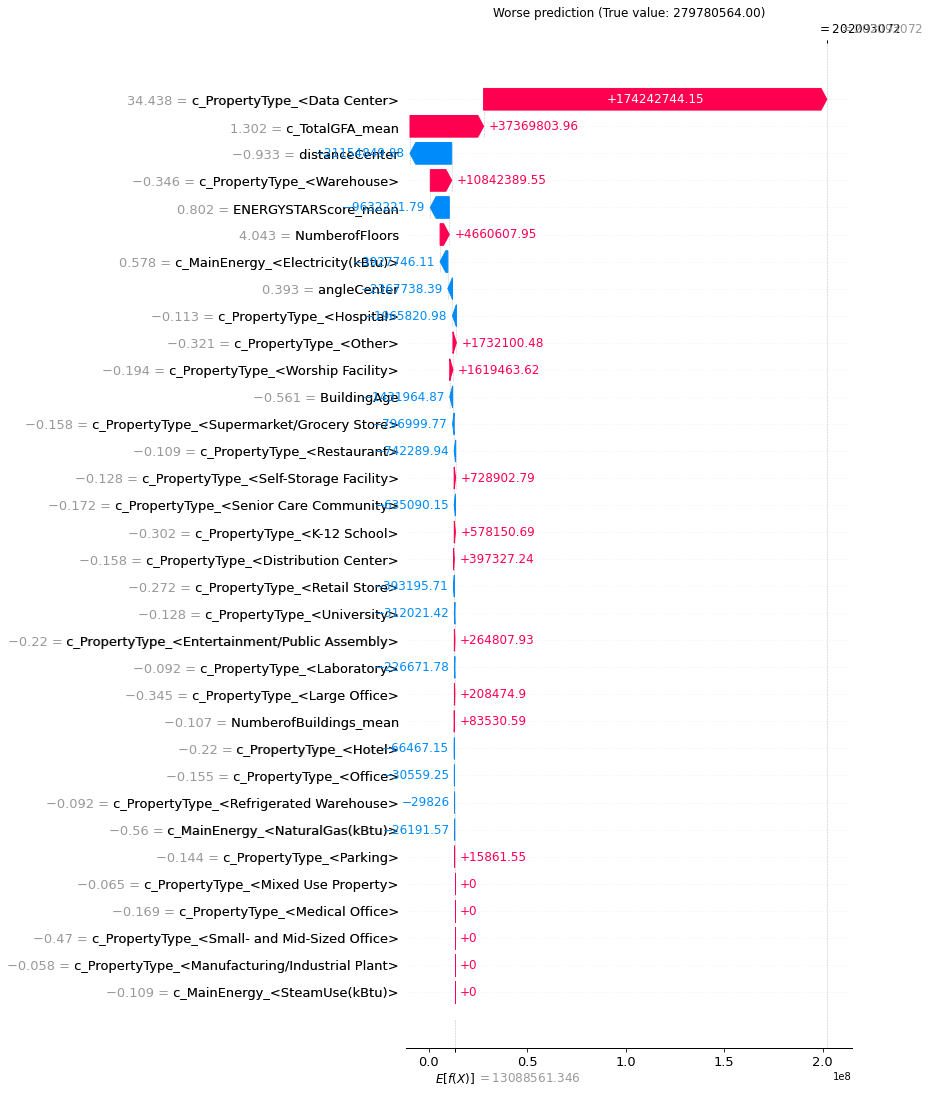

=== SiteEnergyUse wo Energy Star ===


,estimator,R2,MAE_neg,MSE_neg,fit_time,params,predict_time,R2_train
0,Dummy,-0.016499,-0.992908,-1.508583,0.008656,{},0.003185,-0.017391
1,Ridge,0.615380,-0.596613,-0.570814,0.008010,{'alpha': 19},0.002941,0.560233
2,Lasso,0.608930,-0.600697,-0.580385,0.008272,{'alpha': 0.018000000000000002},0.002702,0.563955
3,ElasticNet,0.608257,-0.601140,-0.581385,0.007299,"{'alpha': 0.032, 'l1_ratio': 0.5}",0.002333,0.564066
4,Tree Bagging,0.681304,-0.510558,-0.472975,1.278119,{'n_estimators': 140},0.036669,0.715465
5,RandomForest,0.698528,-0.500595,-0.447413,1.007897,"{'n_estimators': 200, 'max_samples': 0.8, 'max_features': 0.5}",0.045559,0.728247
6,GBoost,0.729350,-0.474264,-0.401671,0.275125,"{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}",0.003312,0.742476
7,XGBoost,0.728043,-0.476797,-0.403610,0.168648,"{'n_estimators': 120, 'learning_rate': 0.1, 'max_depth': 3}",0.017288,0.739533
8,Bagging w Ridge,0.609302,-0.599424,-0.579833,0.581967,"{'n_estimators': 160, 'base_estimator__alpha': 18}",0.216462,0.562638
9,RandomForest w Pfeatures 2,0.680514,-0.512938,-0.474148,1.623055,{'n_estimators': 160},0.405406,0.713336


(11, 8)


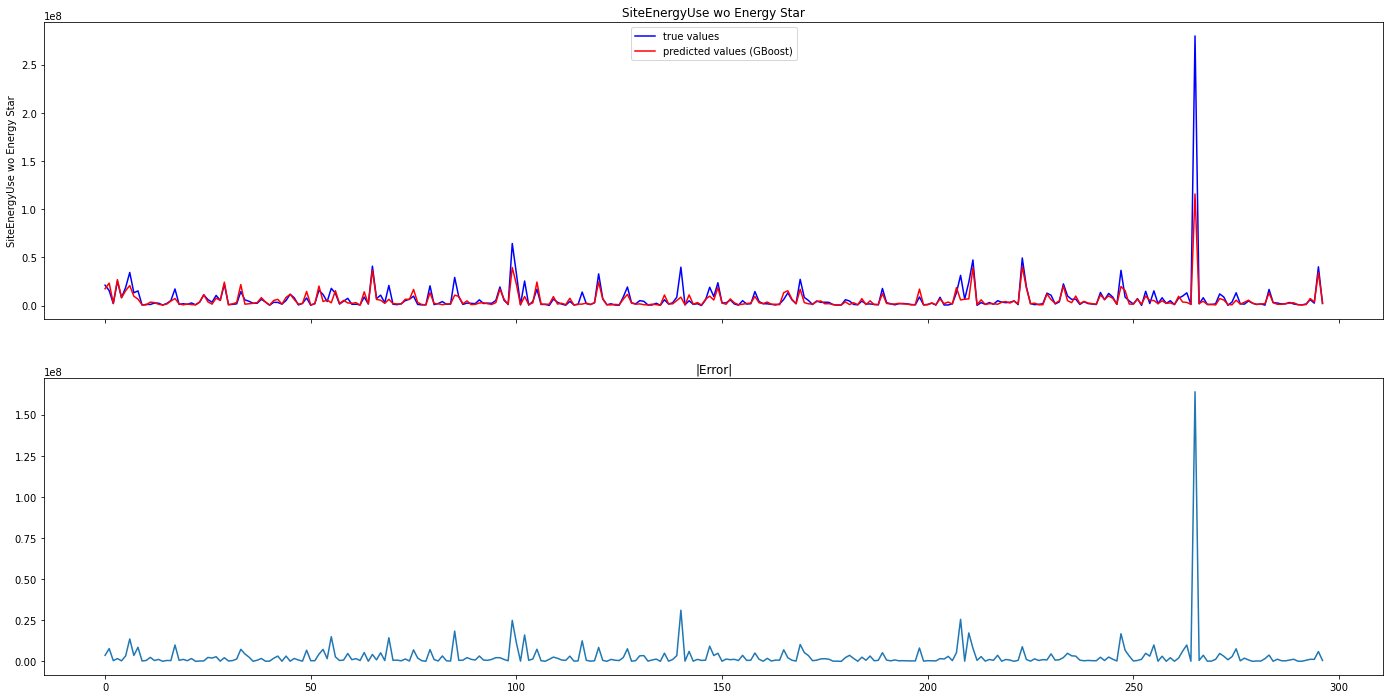

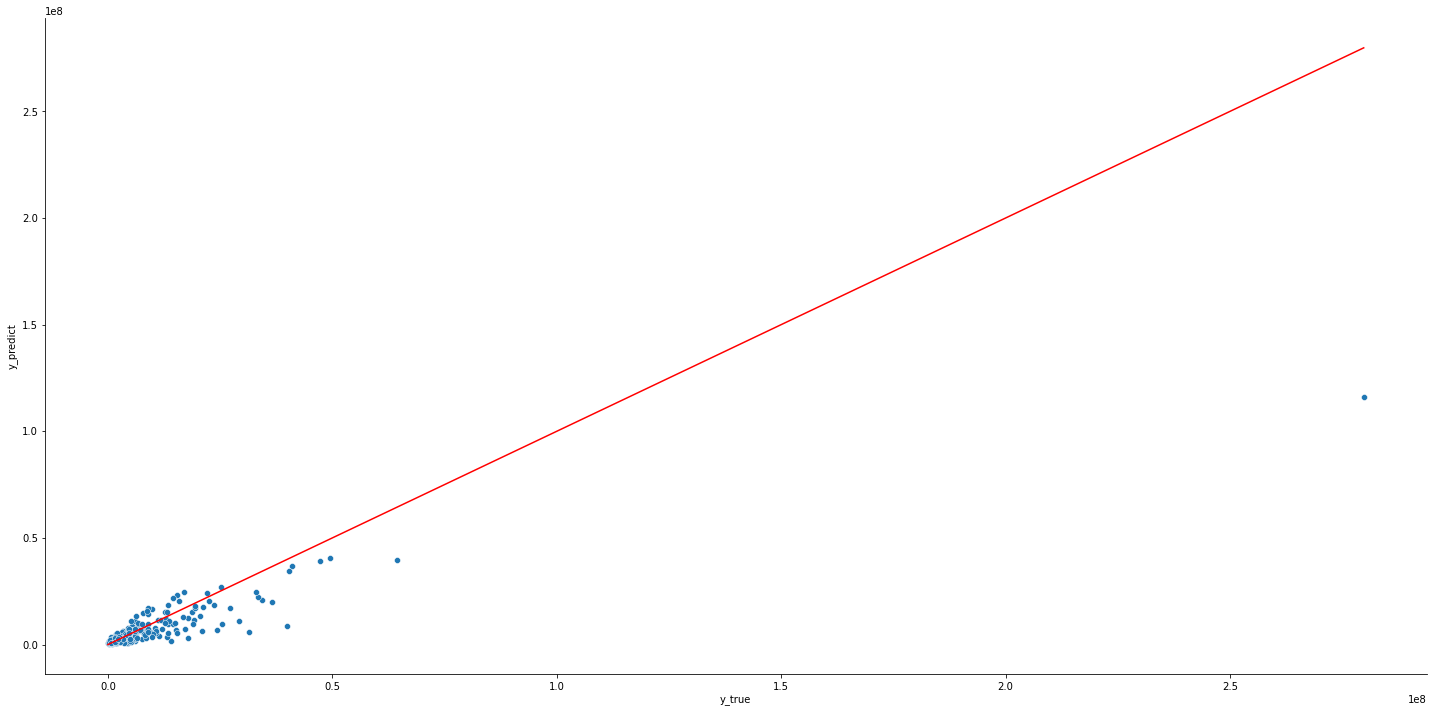

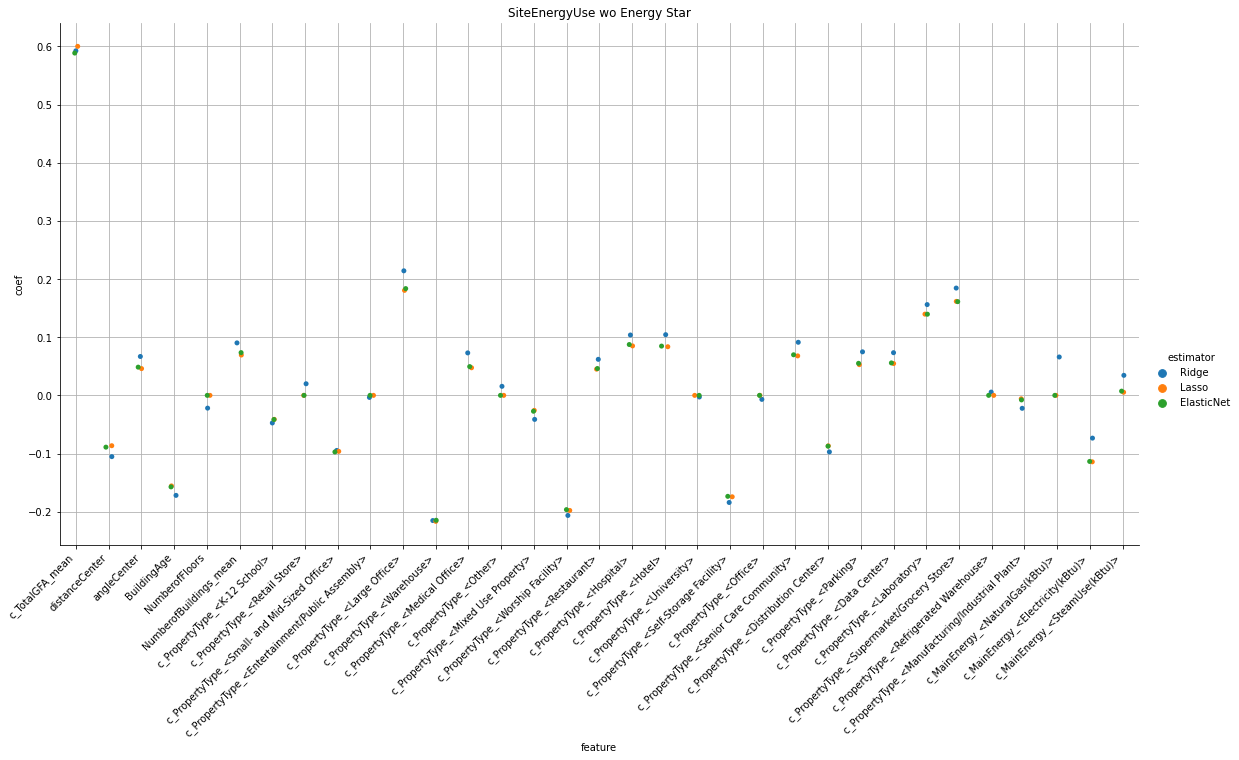

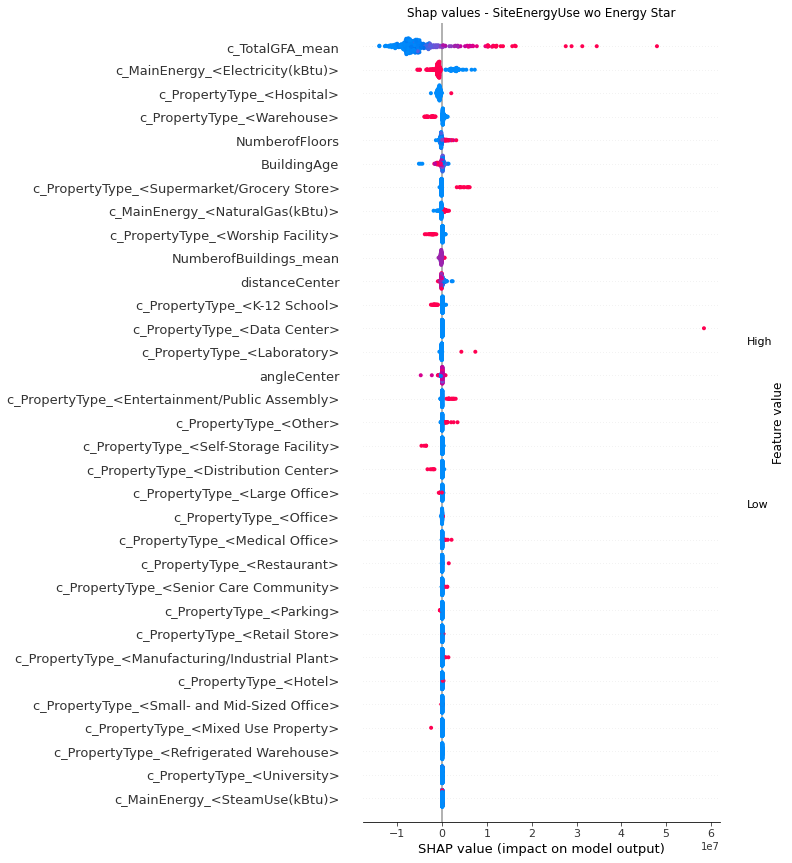

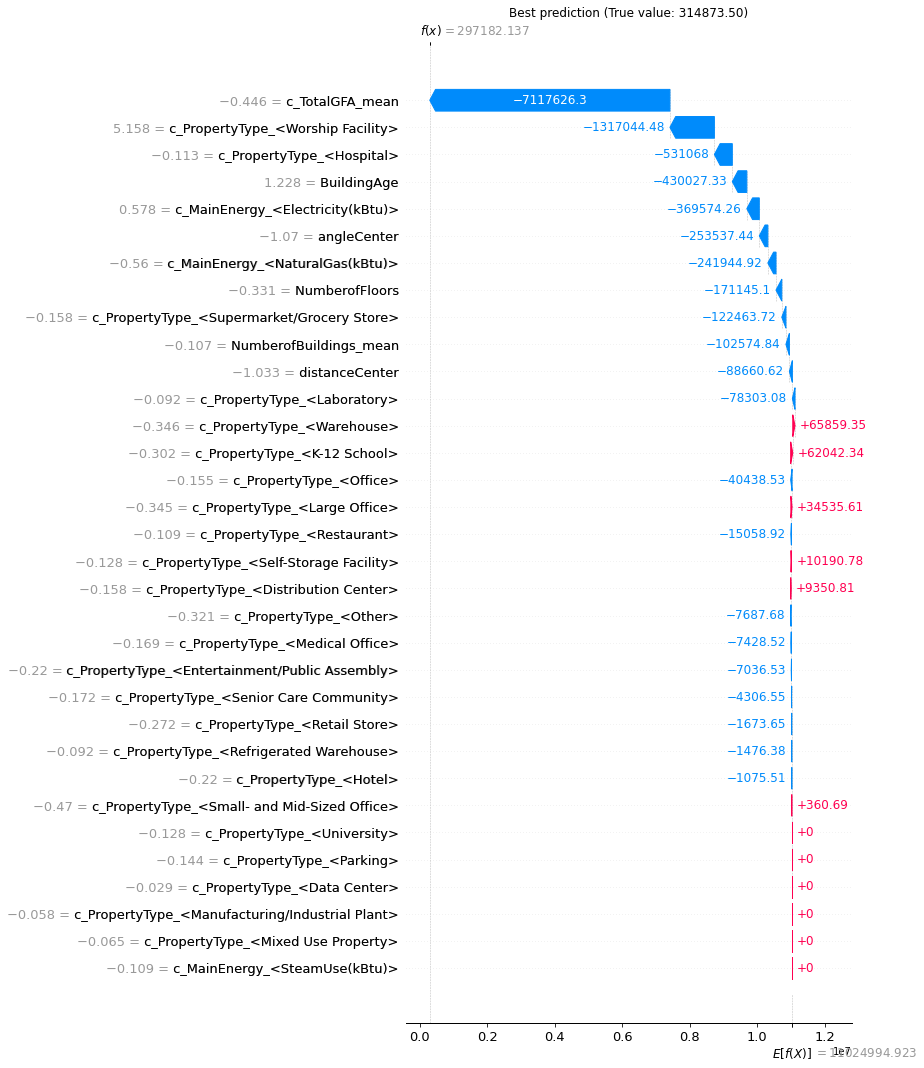

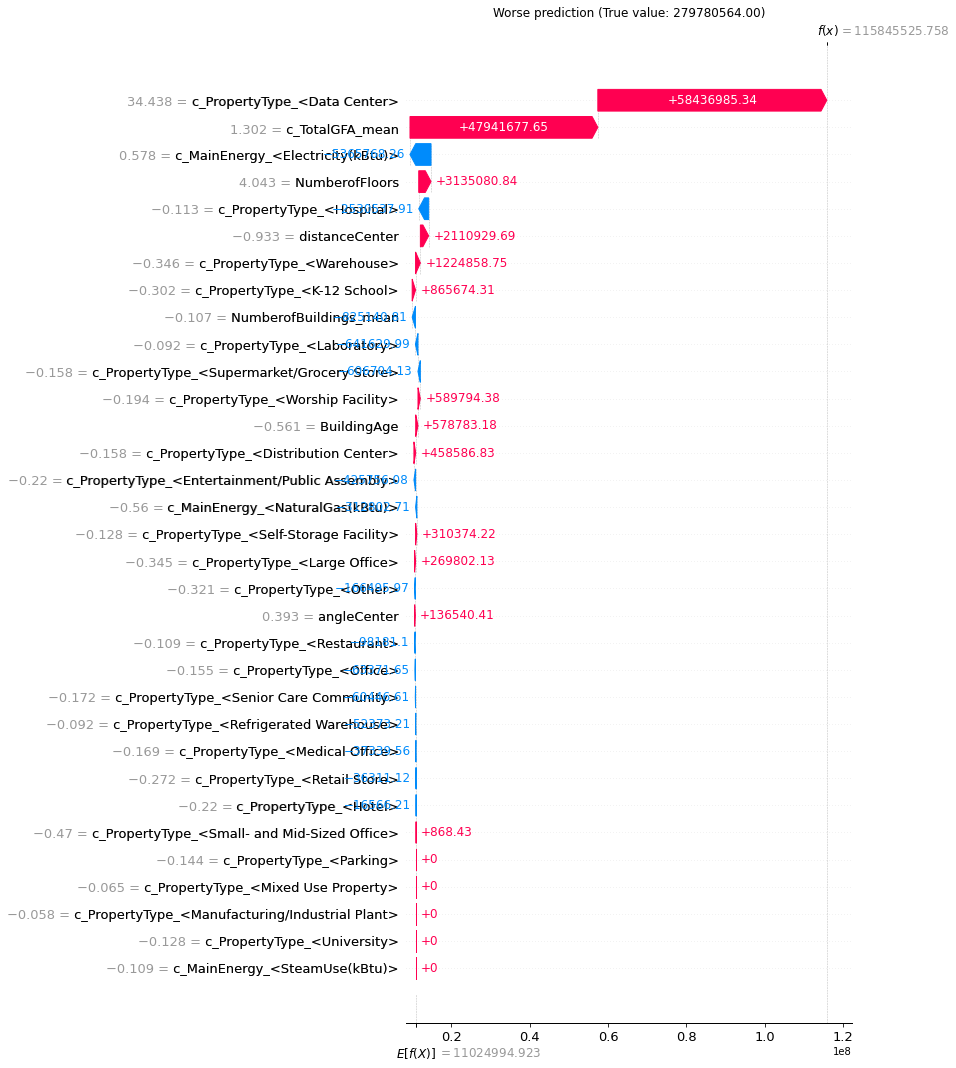

=== GHGEmissions w Energy Star ===


,estimator,R2,MAE_neg,MSE_neg,fit_time,params,predict_time,R2_train
0,Dummy,-0.001403,-1.049837,-1.879712,0.012372,{},0.002286,-0.009439
1,Ridge,0.641540,-0.637070,-0.672857,0.008231,{'alpha': 19},0.002323,0.572590
2,Lasso,0.643677,-0.634350,-0.668846,0.008943,{'alpha': 0.010000000000000002},0.002319,0.573840
3,ElasticNet,0.642911,-0.634585,-0.670284,0.008280,"{'alpha': 0.017, 'l1_ratio': 0.5}",0.002787,0.574083
4,Tree Bagging,0.686501,-0.603503,-0.588463,1.936522,{'n_estimators': 200},0.059224,0.693879
5,RandomForest,0.692826,-0.593441,-0.576591,1.134505,"{'n_estimators': 200, 'max_samples': 0.8, 'max_features': 0.5}",0.044893,0.703039
6,GBoost,0.733816,-0.551873,-0.499649,0.490565,"{'n_estimators': 160, 'learning_rate': 0.1, 'max_depth': 3}",0.004039,0.744585
7,XGBoost,0.740970,-0.544538,-0.486221,0.298546,"{'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3}",0.012525,0.747193
8,Bagging w Ridge,0.637474,-0.640270,-0.680489,0.435151,"{'n_estimators': 120, 'base_estimator__alpha': 9}",0.181472,0.573792
9,RandomForest w Pfeatures 2,0.697256,-0.589699,-0.568275,2.657999,{'n_estimators': 200},0.473731,0.694239


(11, 8)


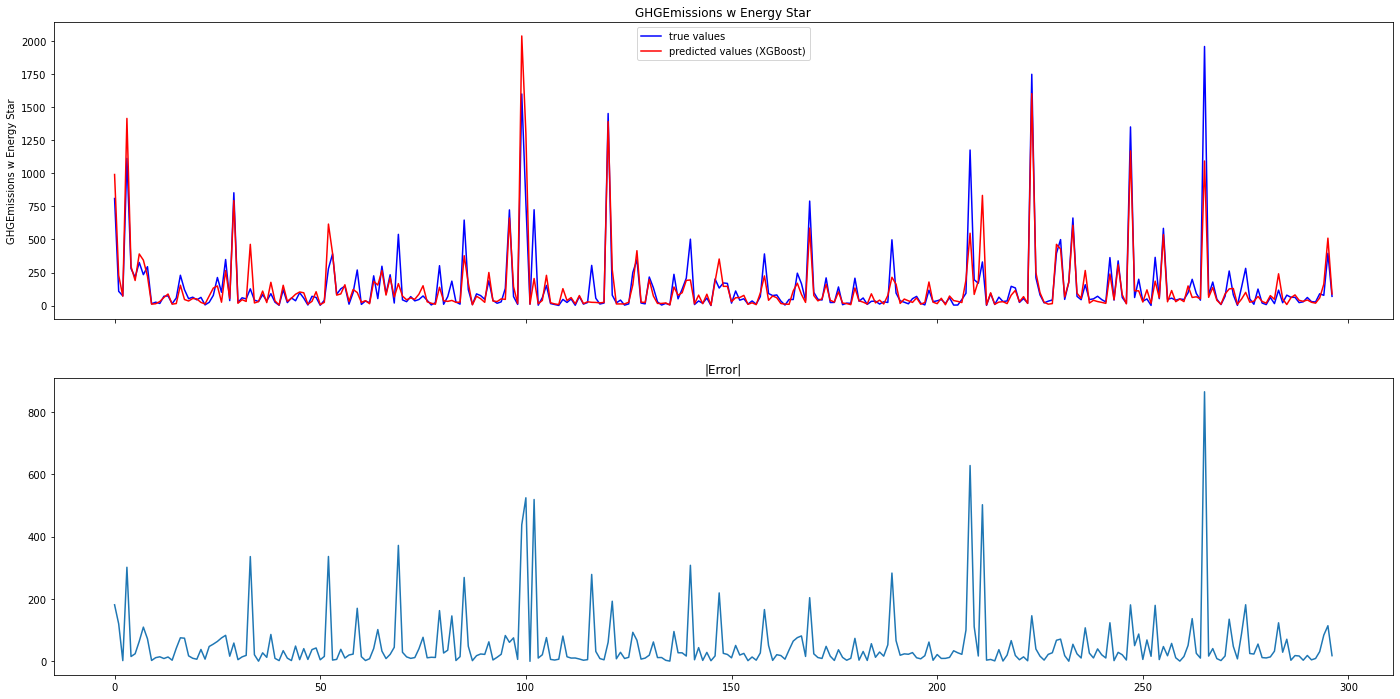

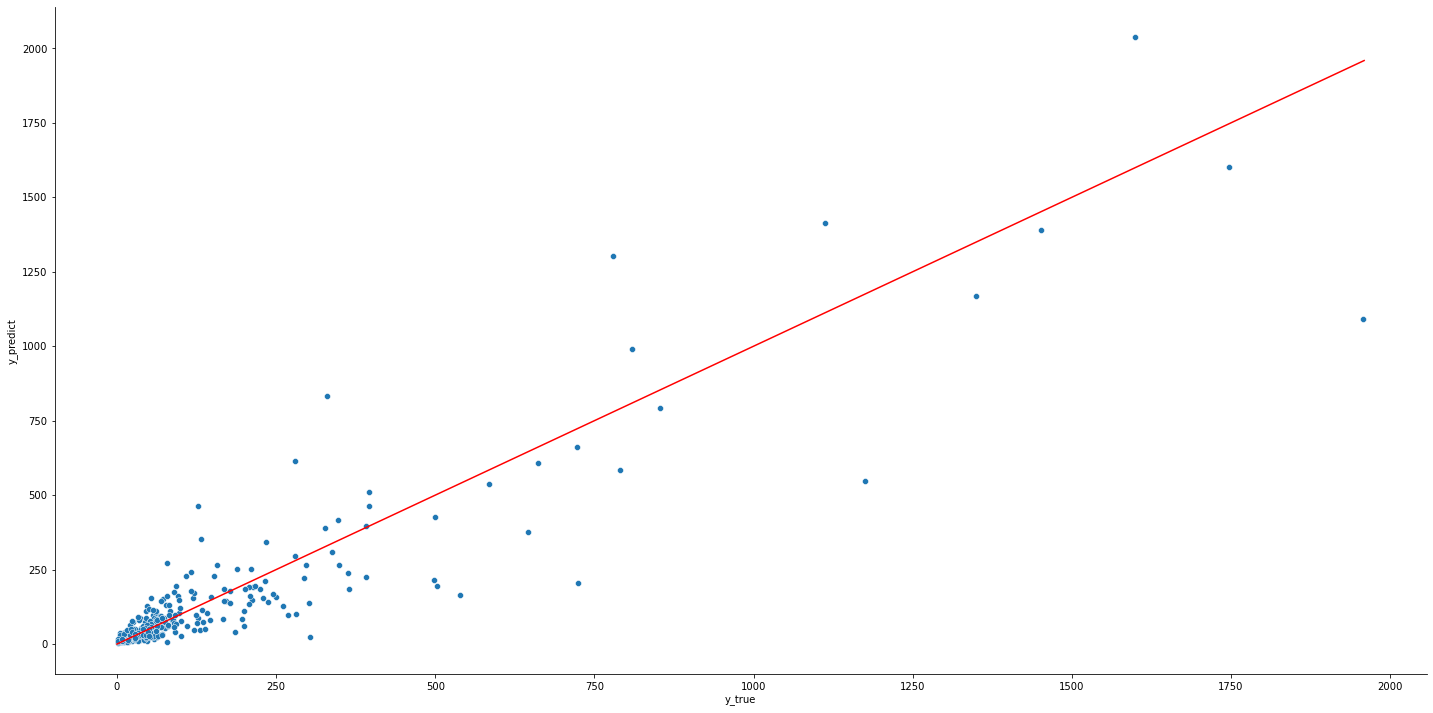

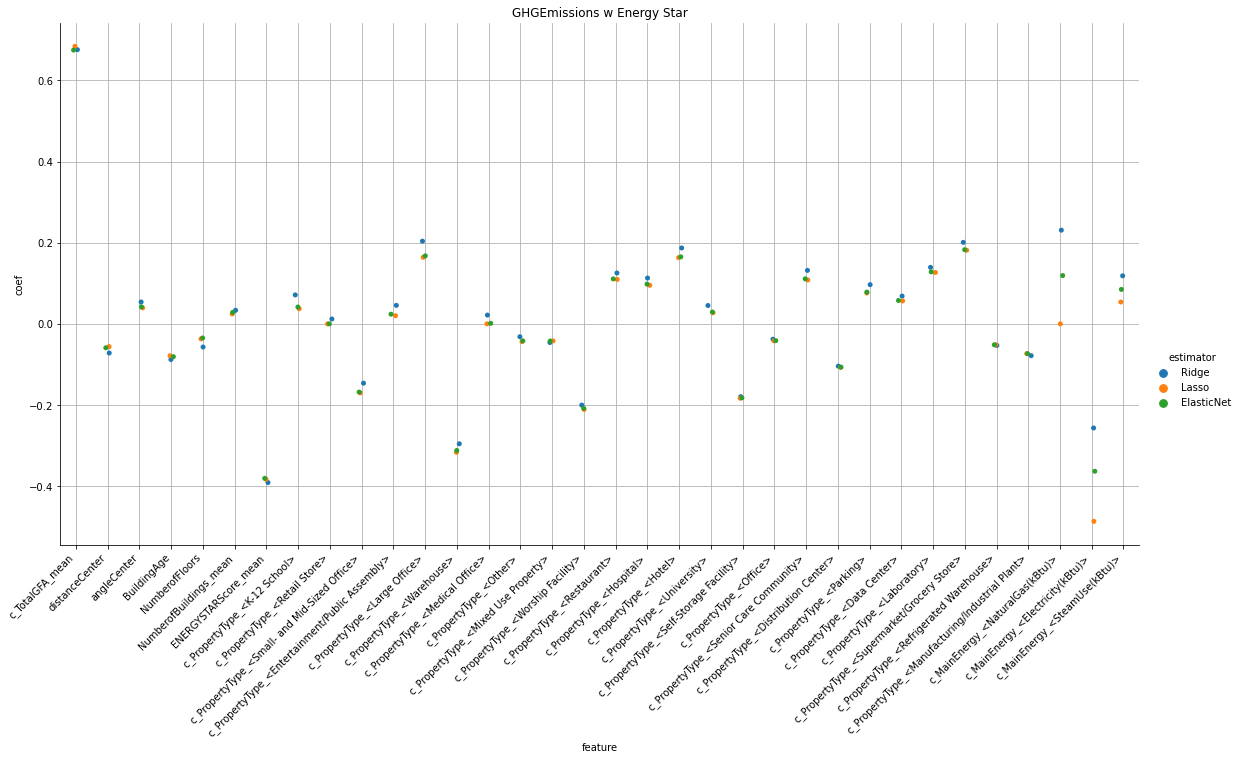

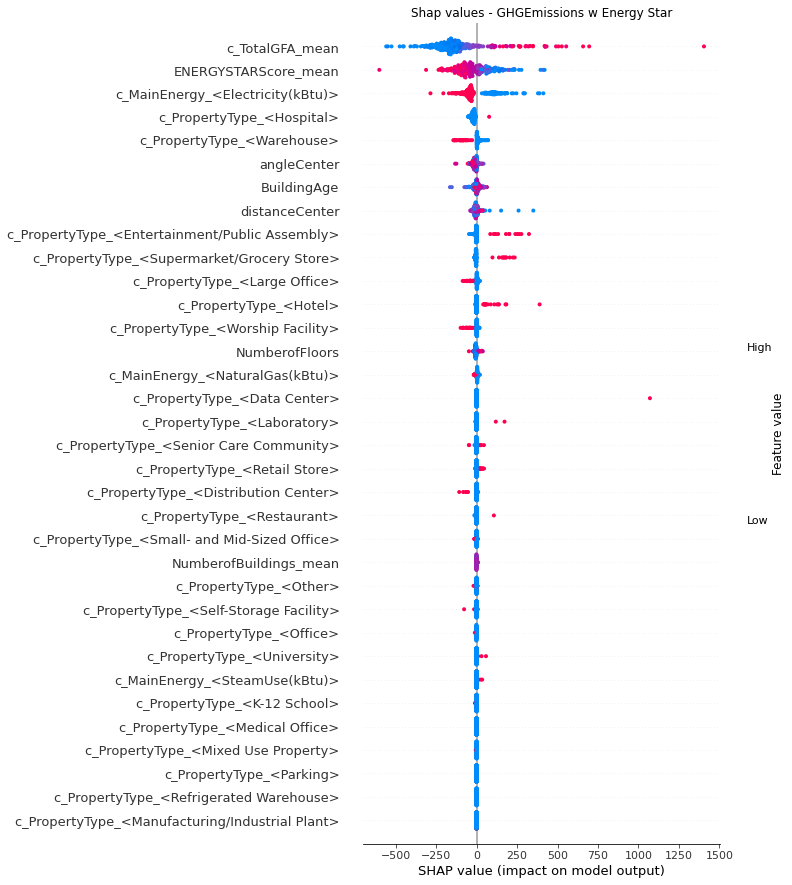

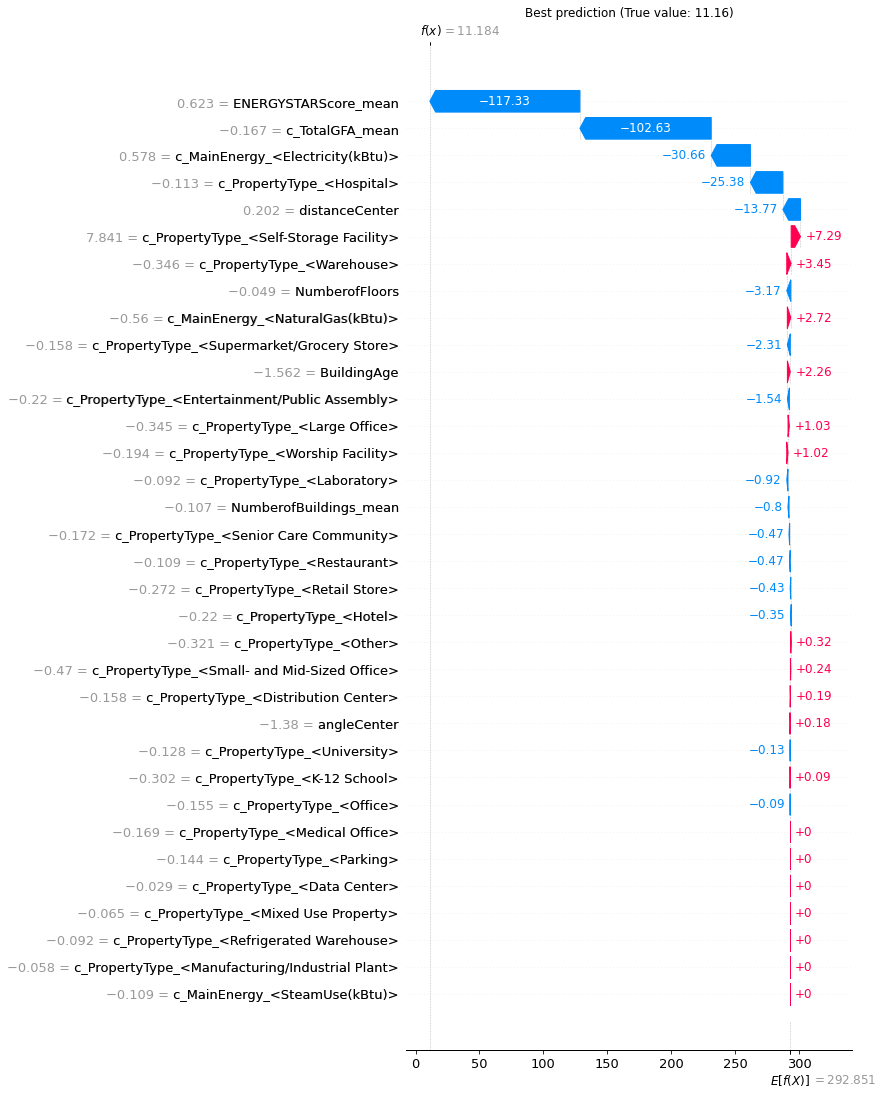

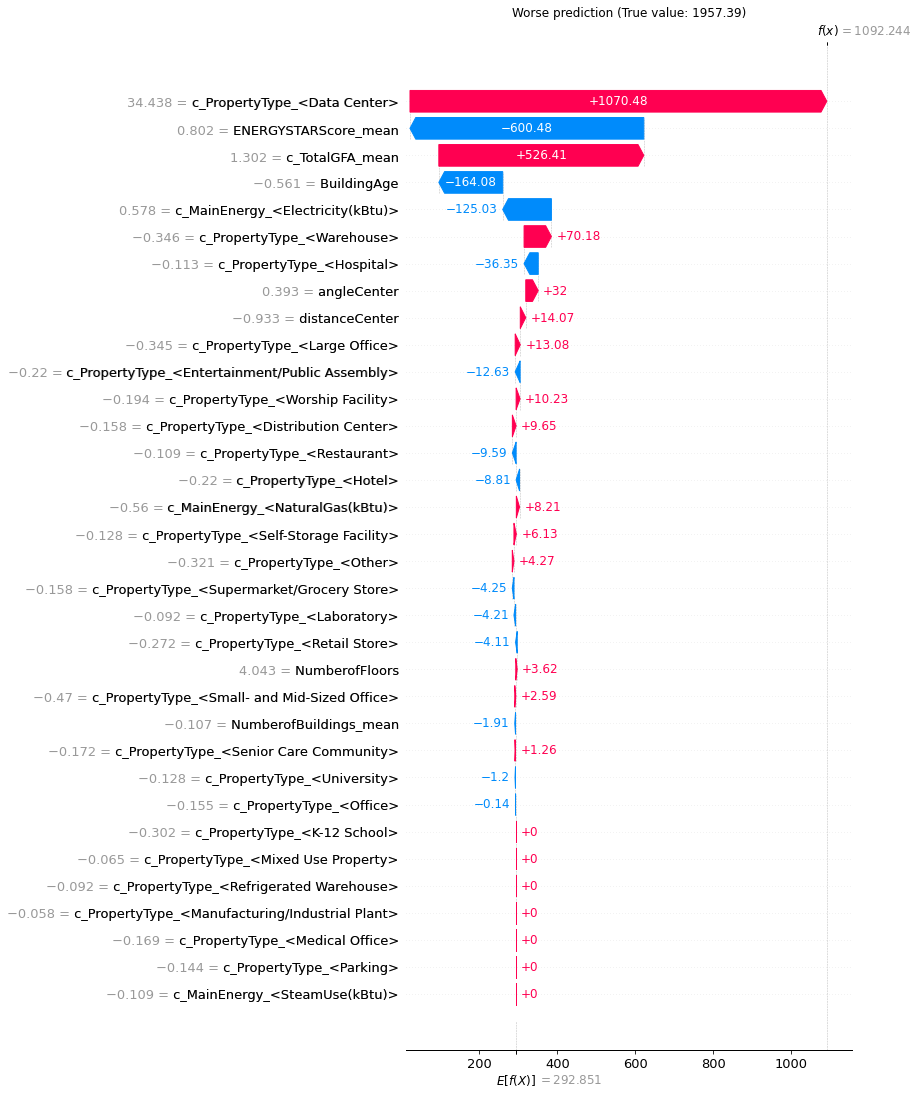

=== GHGEmissions wo Energy Star ===


,estimator,R2,MAE_neg,MSE_neg,fit_time,params,predict_time,R2_train
0,Dummy,-0.001403,-1.049837,-1.879712,0.010190,{},0.002139,-0.009439
1,Ridge,0.531499,-0.718177,-0.879413,0.007731,{'alpha': 19},0.002161,0.514949
2,Lasso,0.532214,-0.714491,-0.878070,0.007910,{'alpha': 0.015},0.002195,0.517193
3,ElasticNet,0.531760,-0.715077,-0.878923,0.007219,"{'alpha': 0.027000000000000003, 'l1_ratio': 0.5}",0.002989,0.517404
4,Tree Bagging,0.542122,-0.717752,-0.859474,2.119308,{'n_estimators': 200},0.050546,0.618642
5,RandomForest,0.581939,-0.677106,-0.784733,0.373710,"{'n_estimators': 120, 'max_samples': 0.8, 'max_features': 0.2}",0.027375,0.637845
6,GBoost,0.606946,-0.663113,-0.737792,0.168033,"{'n_estimators': 60, 'learning_rate': 0.2, 'max_depth': 3}",0.003074,0.641545
7,XGBoost,0.610561,-0.663116,-0.731007,0.229050,"{'n_estimators': 120, 'learning_rate': 0.1, 'max_depth': 3}",0.012008,0.646422
8,Bagging w Ridge,0.528593,-0.719102,-0.884867,0.251295,"{'n_estimators': 60, 'base_estimator__alpha': 15}",0.103058,0.516881
9,RandomForest w Pfeatures 2,0.557828,-0.704077,-0.829992,1.574559,{'n_estimators': 160},0.394176,0.615448


(11, 8)


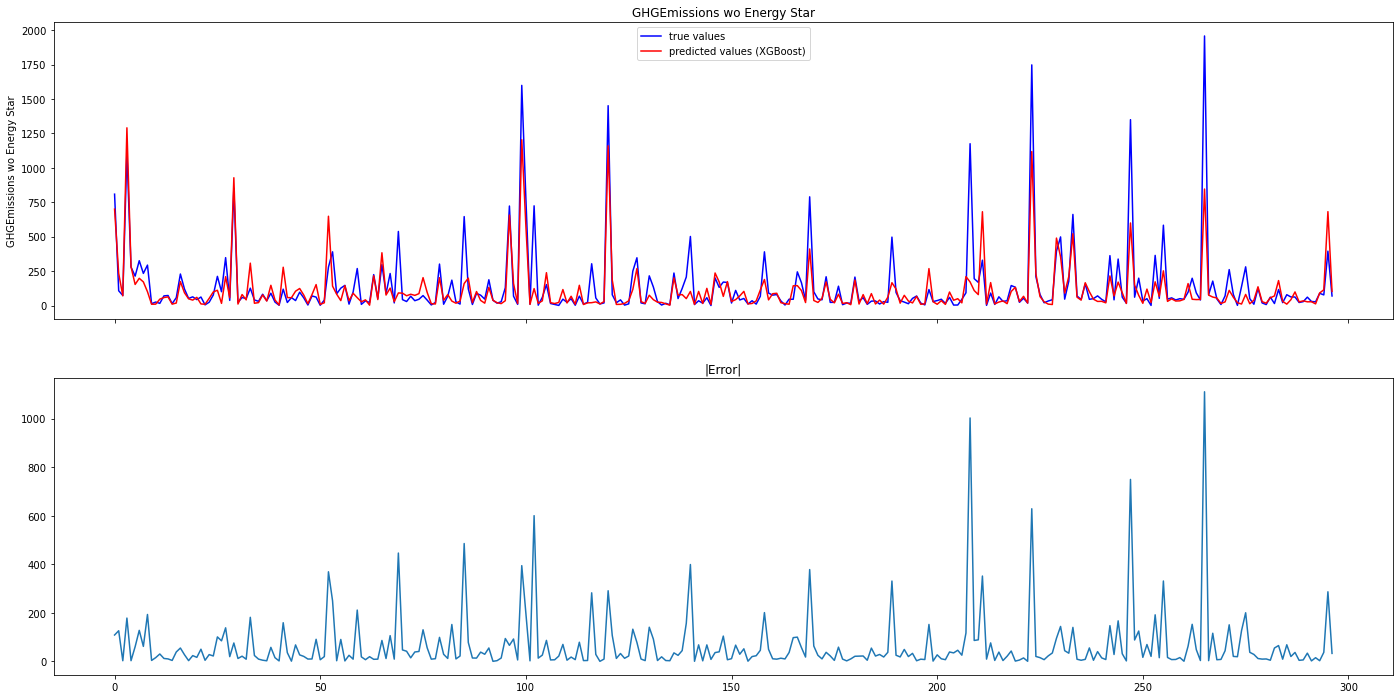

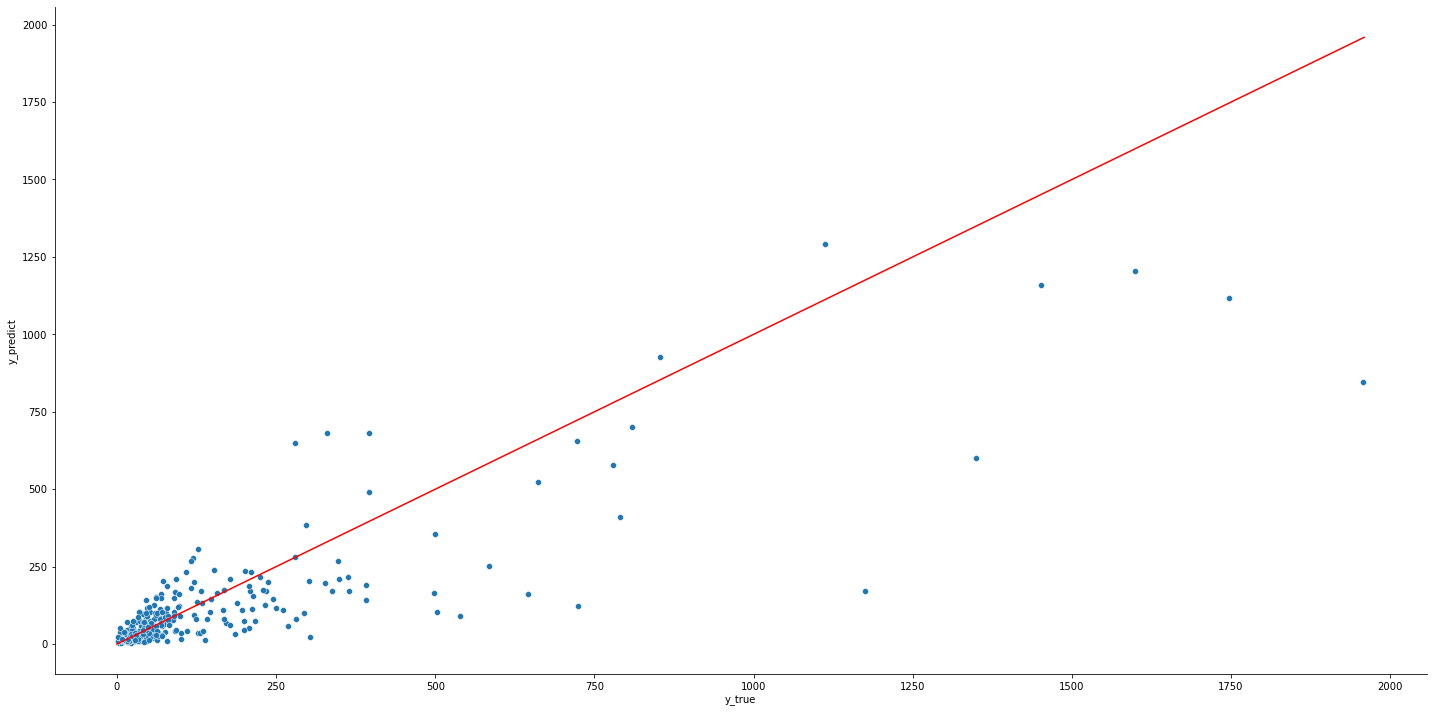

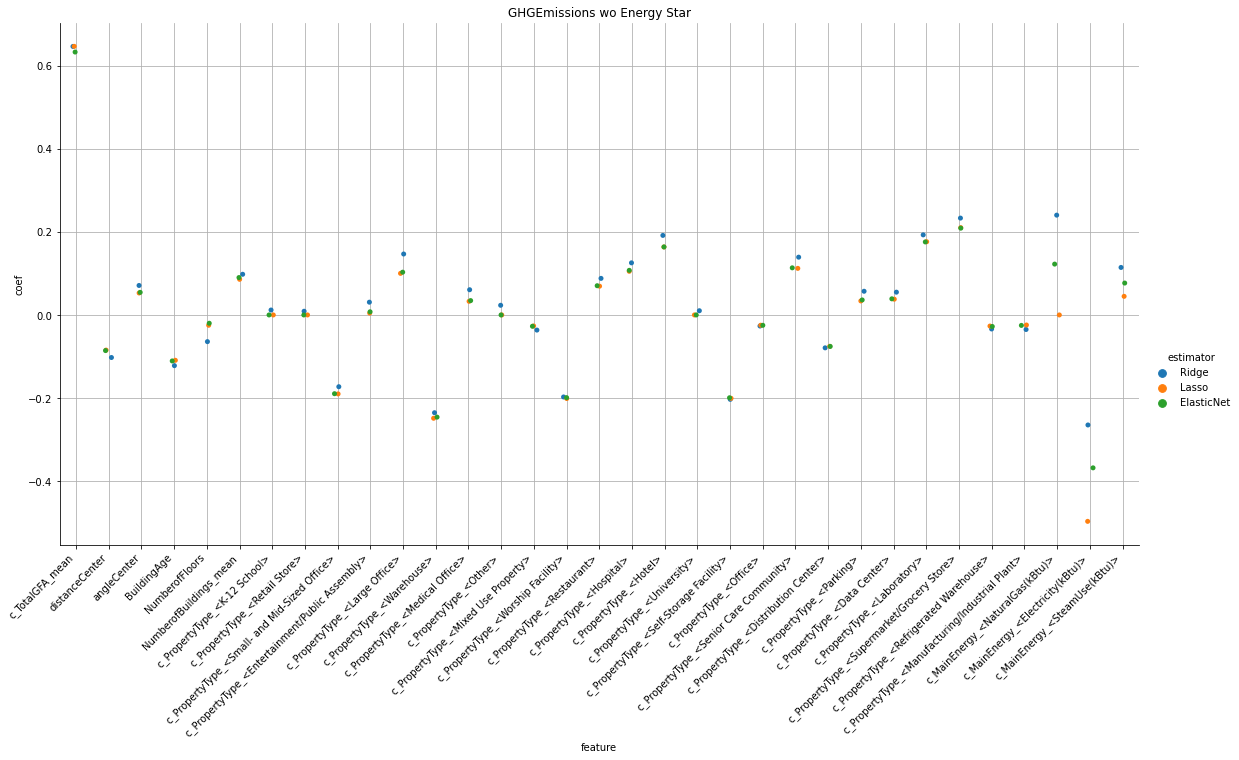

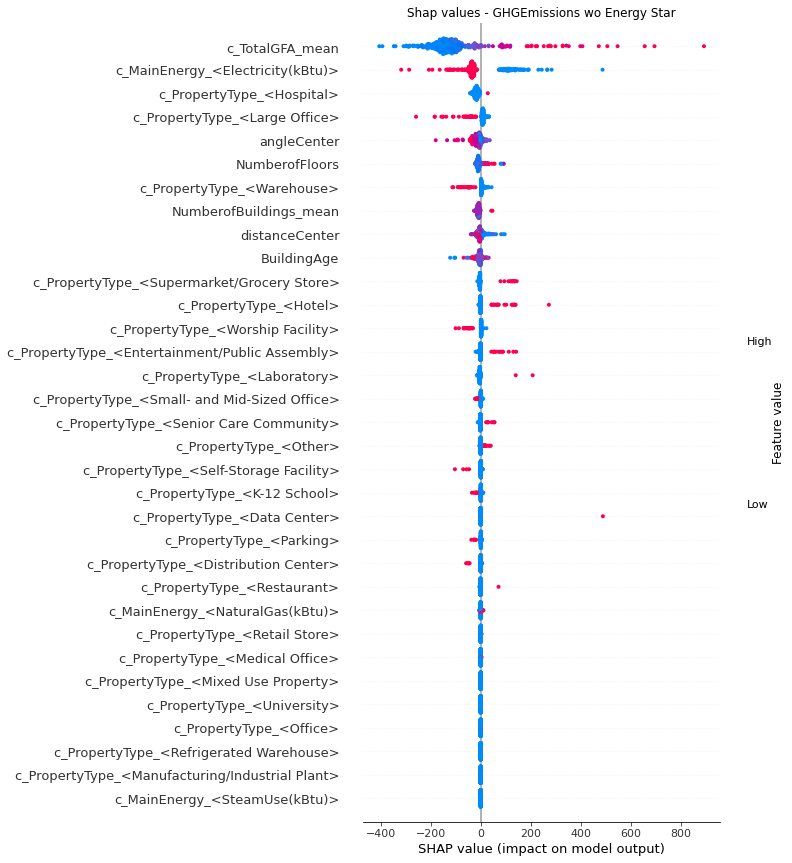

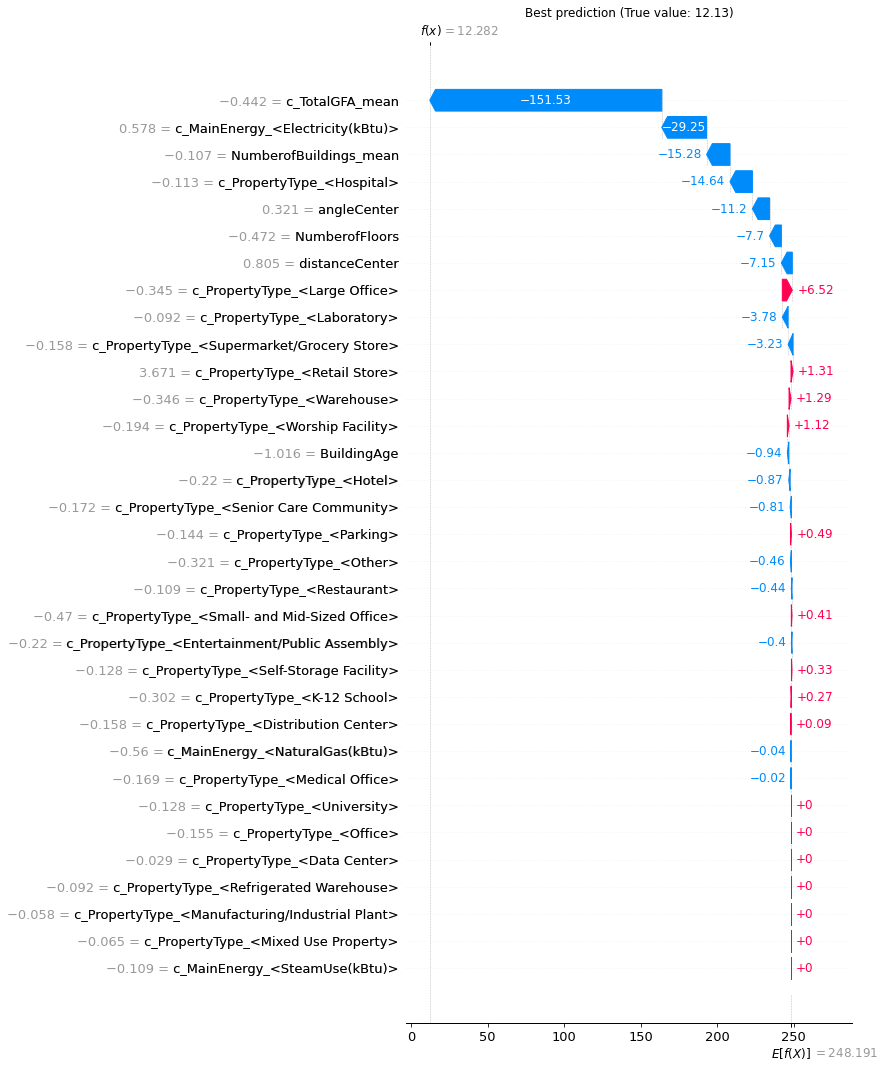

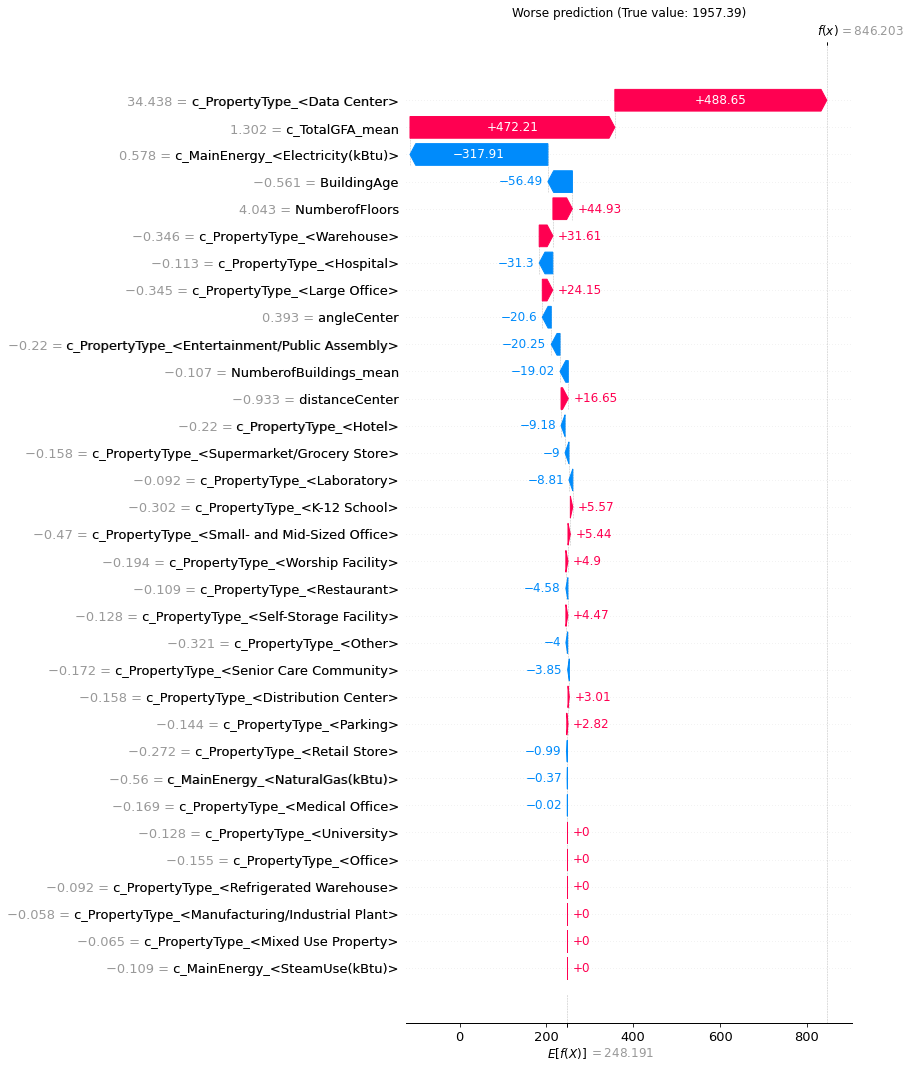

In [8]:
print("=== Global Results ===")
gresults = global_results(results).rename(columns={'R2':'R2_test'})
display_all(gresults.loc[:,['target','estimator','R2_test','MAE_neg','MSE_neg','R2_train','predict_time','fit_time','params']])

for (y,gs) in results.items():
    print(f"=== {y} ===")
    display_all(gridinfo(gs))
    display_predict(y,gs)
    cfs = coefs(gs,reg_estimators)
    display_coefs(cfs,y)
    display_shap(y,gs)